# Audio Frequency - Mean Cross w/ Smoothing

Based on CircuitPython code written by Dan Halbert.

In [1]:
import time
import csv
import matplotlib.pyplot as plt

In [2]:
# knobs
SAMPLERATE = 44000
SAMPLE_THRESH = 100

In [3]:
# load the mic data from file
DATA_FILE = "recorder_c5.dat"

t = []
samples = []
with open(DATA_FILE) as f:
    reader = csv.reader(f)
    for r in reader:
        t.append(float(r[0]))
        samples.append(float(r[1]))
        
NUM_SAMPLES = len(samples)

# RAW DATA

In [4]:
# calc DC offset
mean = int(sum(samples) / len(samples) + 0.5)
threshold = SAMPLE_THRESH + mean

# distance between falling mean-crossing points (mean represents a zero-crossing point)
crossings = []
deltas = []
last_xing_point = -1
high_peak = False
for i in range(NUM_SAMPLES-1):
    sample = samples[i]
    if sample > threshold:
        high_peak = True
    if high_peak and sample < mean:
        if last_xing_point != -1:
            crossings.append(i)
            deltas.append(i - last_xing_point)
        last_xing_point = i
        high_peak = False
        
if not deltas:
    print("No deltas found")
    while True:
        pass
    
# average the crossings
dmean = sum(deltas) / len(deltas)
freq = SAMPLERATE / dmean

In [5]:
# stash current results
raw_mean = mean
raw_thresh = threshold
raw_crossings = crossings
raw_deltas = deltas
raw_dmean = dmean
raw_freq = freq

# SMOOTHED DATA

In [6]:
# smooth the raw data (exponential)
alpha = 0.2
smoothed = [0]*NUM_SAMPLES
smoothed[0] = samples[0]
for i in range(1,NUM_SAMPLES):
    smoothed[i] = alpha*samples[i] + (1 - alpha)*smoothed[i-1]

In [7]:
# calc DC offset
mean = int(sum(smoothed) / len(smoothed) + 0.5)
threshold = SAMPLE_THRESH + mean

# distance between falling mean-crossing points (mean represents a zero-crossing point)
crossings = []
deltas = []
last_xing_point = -1
high_peak = False
for i in range(NUM_SAMPLES-1):
    sample = smoothed[i]
    if sample > threshold:
        high_peak = True
    if high_peak and sample < mean:
        if last_xing_point != -1:
            crossings.append(i)
            deltas.append(i - last_xing_point)
        last_xing_point = i
        high_peak = False
        
if not deltas:
    print("No deltas found")
    while True:
        pass
    
# average the crossings
dmean = sum(deltas) / len(deltas)
freq = SAMPLERATE / dmean

In [8]:
# stash current results
smooth_mean = mean
smooth_thresh = threshold
smooth_crossings = crossings
smooth_deltas = deltas
smooth_dmean = dmean
smooth_freq = freq

# PLOTTING

In [9]:
# make reference data for plotting
t_raw_crossings = []
s_raw_crossings = []
for c in raw_crossings:
    t_raw_crossings.append(t[c])
    s_raw_crossings.append(samples[c])

x_raw_mean = [0, t[-1]]
y_raw_mean = [raw_mean, raw_mean]

x_raw_thresh = [0, t[-1]]
y_raw_thresh = [raw_thresh, raw_thresh]    
    
t_smooth_crossings = []
s_smooth_crossings = []
for c in smooth_crossings:
    t_smooth_crossings.append(t[c])
    s_smooth_crossings.append(smoothed[c])
    
x_smooth_mean = [0, t[-1]]
y_smooth_mean = [smooth_mean, smooth_mean]

x_smooth_thresh = [0, t[-1]]
y_smooth_thresh = [smooth_thresh, smooth_thresh]

In [10]:
info_text  = "RAW: crossings={}  mean={:0.2f}  freq={:0.2f}\n".format(len(raw_deltas), raw_mean, raw_freq)
info_text += "SMOOTHED: crossings={}  mean={:0.2f}  freq={:0.2f}".format(len(smooth_deltas), smooth_mean, smooth_freq)
print(info_text)

RAW: crossings=18  mean=32850.00  freq=824.14
SMOOTHED: crossings=11  mean=32849.00  freq=528.38


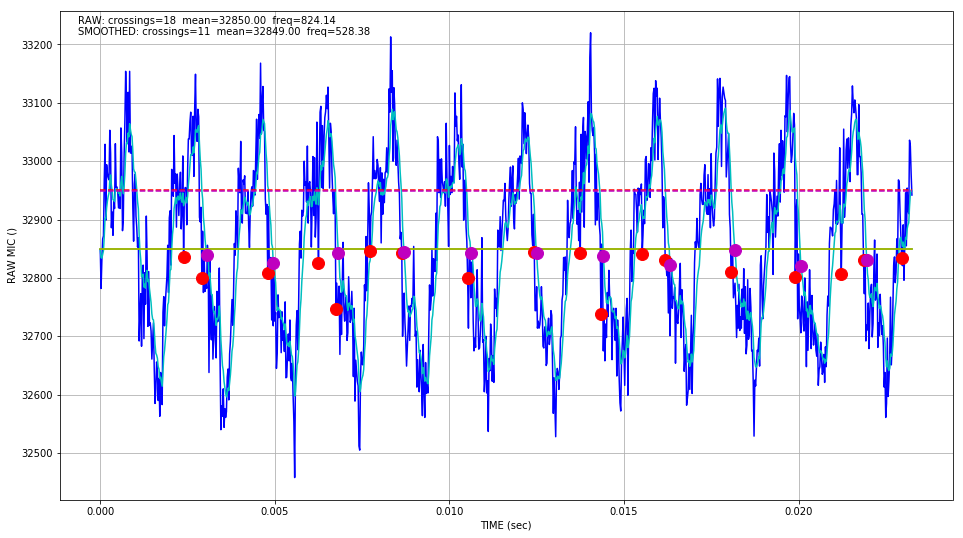

In [11]:
# plot results
fig = plt.figure(figsize=(16,9))
plt.plot(t, samples, "-b")
plt.plot(t, smoothed, "-c")
plt.plot(x_raw_mean, y_raw_mean, "-g")
plt.plot(x_smooth_mean, y_smooth_mean, "-y")
plt.plot(x_raw_thresh, y_raw_thresh, "--r")
plt.plot(x_smooth_thresh, y_smooth_thresh, "--m")
plt.plot(t_raw_crossings, s_raw_crossings, "or", markersize=12)
plt.plot(t_smooth_crossings, s_smooth_crossings, "om", markersize=12)
plt.xlabel("TIME (sec)")
plt.ylabel("RAW MIC ()")
plt.text(0.02, 0.95, info_text, transform=plt.gca().transAxes)
plt.grid(True)